In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns

# Utils

In [2]:
def plot_training_history(history):
    sns.set_style("darkgrid")
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(len(history.history['accuracy'])),
                 y=history.history['accuracy'], label='train accuracy')
    sns.lineplot(x=range(len(history.history['val_accuracy'])),
                 y=history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(
        len(history.history['loss'])), y=history.history['loss'], label='train loss')
    sns.lineplot(x=range(len(history.history['val_loss'])),
                 y=history.history['val_loss'], label='validation loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    return plt

In [3]:
DIR_PATH = "./RWF-2000"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
VAL_DIR = os.path.join(DIR_PATH, "val")

In [4]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
SEQUENCE_LENGTH  = 30
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [5]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = [] # stores the frames
    video_reader = cv2.VideoCapture(video_path) # read video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # get the frames in that video
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1) # find skip interval length

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window) # set current frame position of video
        success, frame = video_reader.read() # read frame

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH)) # resize the frame
        
        normalized_frame = resized_frame / 255 # normalize the frame
        
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [7]:
# def create_dataset(directory_path):
#     '''
#     This function will extract the data of the selected classes and create the required dataset.
#     Returns:
#         features:          A list containing the extracted frames of the videos.
#         labels:            A list containing the indexes of the classes associated with the videos.
#         video_files_paths: A list containing the paths of the videos in the disk.
#     '''

#     # Declared Empty Lists to store the features, labels and video file path values.
#     features = []
#     labels = []
#     video_files_paths = []
    
#     # Iterating through all the classes mentioned in the classes list
#     for class_index, class_name in enumerate(CLASS_NAMES):
#         print(f'Extracting data of class:{class_name}')
#         files_list = os.listdir(os.path.join(directory_path, class_name)) # get list of video files present for that class
        
#         for file_name in files_list:
#             video_file_path = os.path.join(directory_path, class_name, file_name) # get complete path

#             frames = frames_extraction(video_file_path) # extract frames from that video

#             # if the choosen video has frames == SEQUENCE_LENGTH
#             # then add it to the features list else skip the video

#             if(len(frames)==SEQUENCE_LENGTH):
#                 features.append(frames)
#                 labels.append(class_index)
#                 video_files_paths.append(video_file_path)

#     features = np.array(features)
#     labels = np.array(labels)
    
#     return features, labels, video_files_paths

In [6]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def process_video_file(class_index, class_name, directory_path, file_name):
    video_file_path = os.path.join(directory_path, class_name, file_name)
    frames = frames_extraction(video_file_path)
    
    if len(frames) == SEQUENCE_LENGTH:
        return frames, class_index, video_file_path
    return None

def create_dataset(directory_path):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    features = []
    labels = []
    video_files_paths = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for class_index, class_name in enumerate(CLASS_NAMES):
            print(f'Extracting data of class: {class_name}')
            files_list = os.listdir(os.path.join(directory_path, class_name))
            
            for file_name in files_list:
                futures.append(executor.submit(process_video_file, class_index, class_name, directory_path, file_name))
        
        for future in futures:
            result = future.result()
            if result:
                frames, class_index, video_file_path = result
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

In [7]:
features_train, labels_train, video_files_paths_train = create_dataset(TRAIN_DIR)
one_hot_encoded_labels_train = to_categorical(labels_train)

Extracting data of class: Fight
Extracting data of class: NonFight


In [8]:
features_val, labels_val, video_files_paths_val = create_dataset(VAL_DIR)
one_hot_encoded_labels_val = to_categorical(labels_val)

Extracting data of class: Fight
Extracting data of class: NonFight


In [11]:
# f_train, f_test, l_train, l_test = train_test_split(features, one_hot_encoded_labels,
#                                                    test_size = 0.25, shuffle = True,
#                                                    random_state = seed)

# Training Model

In [13]:
def create_convlstm_model():
    model = Sequential()
    
    model.add(layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, 
                        input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3), 
                        return_sequences = True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    model.summary()
    
    return model

def create_gru_model():
    model = Sequential()
    
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    model.add(layers.GRU(128, return_sequences=True, recurrent_dropout=0.2))
    model.add(layers.GRU(128, recurrent_dropout=0.2))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

    model.summary()
    
    return model
    


In [14]:
# conv_lstm = create_convlstm_model()
conv_lstm = create_gru_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, 30, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 30, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 30, 12, 12,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 6, 6, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 30, 4608)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 30, 128)        │     1,819,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,028,482 (7.74 MB)

 Trainable params: 2,028,482 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
%%time
EPOCH = 50
BATCH_SIZE = 12
VALIDATION_SPLIT = 0.2

# we can call Early Stopping Callback if we need
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# compile the model with loss as categorical_crossentropy

conv_lstm.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                 metrics=['accuracy'])

# train the model
conv_lstm_train_hist = conv_lstm.fit(x = features_train, 
                                     y = one_hot_encoded_labels_train,
                                     epochs = EPOCH,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     validation_split=VALIDATION_SPLIT,
                                     callbacks = [early_stopping_callback])

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.5952 - loss: 0.7000 - val_accuracy: 0.3333 - val_loss: 0.7752
Epoch 2/50
102/106 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6366 - loss: 0.6646 

KeyboardInterrupt: 

In [17]:
model_evaluation_history = conv_lstm.evaluate(features_val, one_hot_encoded_labels_val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - accuracy: 0.7154 - loss: 0.5708


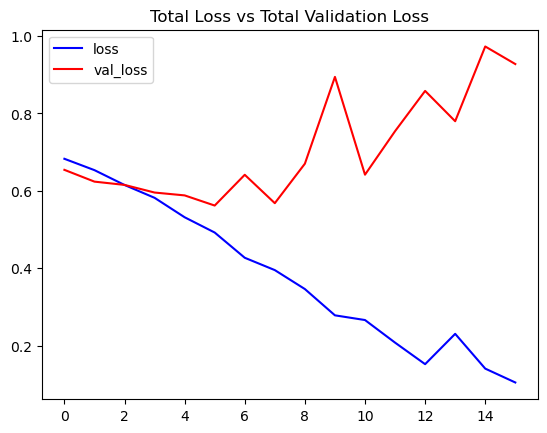